# GLM Demo: univariate stimulus, biophysical dynamics

This is a demo notebook for the GLM estimation algorithm. Here we simulate data using the biophysical dynamical cascade model, and then try to estimate parameters with the GLM. The GLM does not have a membrane, so the estimated RF should be the convolution of the input kernel ($k1$) with the membrane kernel ($k2$) which is approximately an exponential decay with time constant $\tau_m$. However, what can happen is that the kernel gets shifted to shorter lags for the phasic model, which is consistent with what Chen and Meliza (2018) found for the coherence between an input current and the spiking output - the dynamics act as a bandpass filter.

This notebook also introduces the use of a raised cosine basis set to reduce the number of parameters in the kernel estimate.

In [1]:
from __future__ import print_function, division
import sys
import imp
import os
import numpy as np
import scipy as sp
import scipy.signal as sps
import quickspikes as qs

import mat_neuron._model as mat
from dstrf import strf, mle, filters
import spyks.core as spkc

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

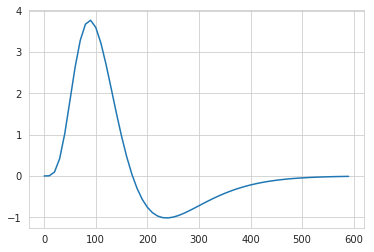

In [2]:
model_dt = 0.5
stim_dt = 10.0

# decay times for exponential adaptation basis set
ataus = np.asarray([10, 200], dtype='d')

# convolution kernel
ntau = 60
upsample = int(stim_dt / model_dt)
ntbas = 8
kscale = 2.0

k1, kt = filters.gammadiff(ntau * stim_dt / 32, ntau * stim_dt / 16, 5, ntau * stim_dt, stim_dt)
k1 = k1 * kscale
plt.plot(kt, k1)

# raised-cosine basis functions
kcosbas = strf.cosbasis(ntau, ntbas)
ntbas = kcosbas.shape[1]
k1c = strf.to_basis(k1, kcosbas)

## Generate the stimulus and response

We are also using gaussian white noise here.

In [3]:
# generating spikes with biocm
# this needs to be adjusted on a per model basis. posp ~ 2.0; phasic ~ 10
# model_name = "biocm_phasic"
# current_scaling = 9.0
model_name = "biocm_tonic"
current_scaling = 4.0
# model_name = "pospischil_sm"
# current_scaling = 2.0

trial_noise_sd = 2.0
spike_thresh = -20
dt_rise_time = int(1.0 / model_dt)
modelpath = "../../models"
pymodel = spkc.load_model(os.path.join(modelpath, model_name + ".yml"))
biocm_params = spkc.to_array(pymodel["parameters"])
biocm_state0 = spkc.to_array(pymodel["state"])
biocm_model = spkc.load_module(pymodel, modelpath)
    
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="full")[:S.size]

def generate_spikes(I, noise_sd, dt, upsample):
    from scipy.signal import resample
    I_noise = np.random.randn(I.size) * noise_sd
    I = current_scaling * (I + I_noise)
    #I_resamp = sps.resample(I + I_noise, I.size * upsample)
    X = biocm_model.integrate(biocm_params, biocm_state0, I, stim_dt, model_dt)
    det = qs.detector(spike_thresh, dt_rise_time)
    return I, X[:, 0], det(X[:, 0])

In [4]:
# data parameters
duration = 100000
n_bins = int(duration / model_dt)
n_frames = n_bins // upsample
n_assim = 10
n_test = 10

# generate data to fit
np.random.seed(1)
mat.random_seed(1)
data = []
stim = np.random.randn(n_frames)
stim[:100] = 0
        
I = filter_stimulus(stim, k1)
for i in range(n_assim):
    In, V, spike_t = generate_spikes(I, trial_noise_sd, model_dt, upsample)
    spike_v = np.zeros(V.size, 'i')
    spike_v[spike_t] = 1
    H = mat.adaptation(spike_v, ataus, model_dt)
    d = {"H": H,
         "duration": duration,
         "spike_t": np.asarray(spike_t), 
         "spike_v": spike_v,
        }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:]

spikes: 483.7; rate: 0.004837 / dt


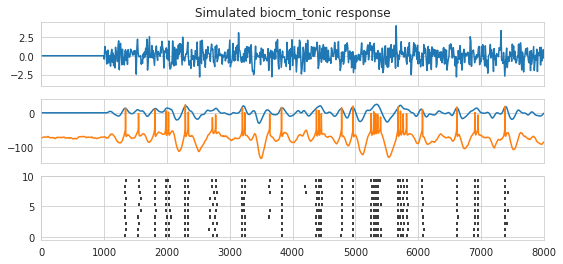

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9, 4))
t_stim = np.linspace(0, duration, stim.size)
t_voltage = np.linspace(0, duration, V.size)
axes[0].set_title("Simulated {} response".format(model_name))
axes[0].plot(t_stim, stim)
axes[1].plot(t_stim, I, t_voltage, V)
for i, d in enumerate(data):
    axes[2].vlines(d["spike_t"] * model_dt, i, i + 0.5)
for ax in axes:
    ax.set_xlim(0, 8000)
print("spikes: {}; rate: {} / dt".format(np.mean([d["spike_t"].size for d in data]), 
                                         np.mean([d["spike_t"].size / d["duration"] for d in data])))

## Estimation

The theano code for setting up maximum likelihood estimation has been factored out into the `mle` package.

**Note**: The following cell sometimes generates an error the first time you run it. Just run it again if that happens.

In [6]:
# initial guess of parameters using regularized ML
ntbas = 8
kcosbas = strf.cosbasis(ntau, ntbas)
spike_v = np.stack([d["spike_v"] for d in assim_data], axis=1)
spike_h = np.stack([d["H"] for d in assim_data], axis=2)
try:
    mlest = mle.mat(stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
except TypeError:
    mlest = mle.mat(stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")
%time w0 = mlest.estimate(reg_alpha=1.0)

Optimization terminated successfully.
         Current function value: 17173.895039
         Iterations: 43
         Function evaluations: 71
         Gradient evaluations: 113
         Hessian evaluations: 290
CPU times: user 58.6 s, sys: 7.71 s, total: 1min 6s
Wall time: 1min 6s


MLE rate and adaptation parameters: [   7.41516545  115.11548256    1.58764703]


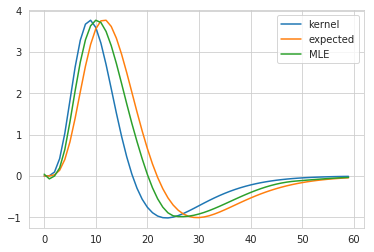

In [7]:
print("MLE rate and adaptation parameters:", w0[:3])
rf_ml = strf.from_basis(w0[3:], kcosbas)[::-1]
plt.plot(k1, label="kernel")

# there is an expected shift due to the filtering properties of the membrane
km, kmt = filters.exponential(46, 1.0, ntau * stim_dt, stim_dt)
kconv = np.convolve(km, k1, mode="full")[:km.size]
kconv *= k1.max() / kconv.max()
plt.plot(kconv, label="expected")

plt.plot(rf_ml * k1.max() / rf_ml.max(), label="MLE")
plt.legend()

## Posterior sampling

The following cells sample from the posterior distribution of the parameters. This is useful if you want to do inference or generate plots showing the posteriors.

In [8]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

# assimilation parameters
if sys.platform == 'darwin':
    nthreads = 1
else:
    nthreads = 8
nwalkers = 500
nsteps = 200

mat_prior = priors.joint_independent(
                [ priors.uniform( 0,  20),
                  priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                ])

# lasso prior on RF parameters
rf_lambda = 1.0

# set boundaries on adaptation parameters based on disallowed region (see Yamauchi et al 2011)
def matbounds(t1, t2, tr):
    aa1 = -(1 - np.exp(-tr/t2))/(1 - np.exp(-tr/t1))
    aa2 = -(np.exp(tr/t2) - 1)/(np.exp(tr/t1) - 1)
    def f(mparams):
        return (mparams[2] > aa1 * mparams[1]) and (mparams[2] > aa2 * mparams[1])
    return f

# refractory period - used to set bounds for a1 and a2
t_refract = 2.0
matboundprior = matbounds(ataus[0], ataus[1], t_refract)

def lnprior(theta):
    mparams = theta[:3]
    rfparams = theta[3:]
    if not matboundprior(mparams):
        return -np.inf
    rf_prior = -np.sum(np.abs(rfparams)) * rf_lambda
    ll = mat_prior(mparams) + rf_prior
    if not np.isfinite(ll):
        return -np.inf
    else:
        return ll


def loglike_poisson(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    return mu[spike_t].sum() - np.exp(mu).sum() * dt 


def loglike_sigmoid(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    lmb = (1 + np.tanh(mu / 2)) / 2
    return np.log(lmb[spike_t]).sum() - lmb.sum() * dt 


def loglike_softplus(V, H, spike_t, alpha, dt):
    mu = V - np.dot(H, alpha)
    lmb = np.log1p(np.exp(mu))
    return np.log(lmb[spike_t]).sum() - lmb.sum() * dt 
    
    
def lnlike(theta):
    mparams = theta[:3]
    rfparams = theta[3:]
    Vi = mlest.V_interp(theta).squeeze() - mparams[0]
    lp = 0
    for d in assim_data:
        lp += loglike_softplus(Vi, d["H"], d["spike_t"], mparams[1:3], model_dt)
    return lp   

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    return lnprior(theta) - mlest.loglike(theta) #+ lnlike(theta) 
    

In [9]:
# initial state is a gaussian ball around the ML estimate
p0 = startpos.normal_independent(nwalkers, w0, np.abs(w0) * 2)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(w0)

lnpost of p0 median: -17365.70382888622
72.5 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
sampler = emcee.EnsembleSampler(nwalkers, w0.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps)): 
    continue

  step  μ(lnprob)  Δ(lnprob)  σ(lnprob)        time         ETA
---------------------------------------------------------------
    25     -24535        inf      75667     0:02:38     0:19:18
    50     -17316     7219.3     126.79     0:05:16     0:16:14
    75     -17207      109.4       9.45     0:07:54     0:13:28
   100     -17197     9.7028     3.0677     0:10:32     0:10:44
   125     -17196     1.5342     2.3948     0:13:09     0:08:04
   150     -17195    0.40788     2.3457     0:15:48     0:05:24
   175     -17195    0.25283     2.3236     0:18:27     0:02:45
   200     -17195    0.05697     2.2616     0:21:06     0:00:06
   201     -17195   -0.10655     2.4514     0:21:12     0:00:00


lnpost of p median: -17194.578681359966
average acceptance fraction: 0.39215999999999995
MLE: [   7.41516545  115.11548256    1.58764703]
MAP: [   7.41282438  114.97487704    1.59346249]


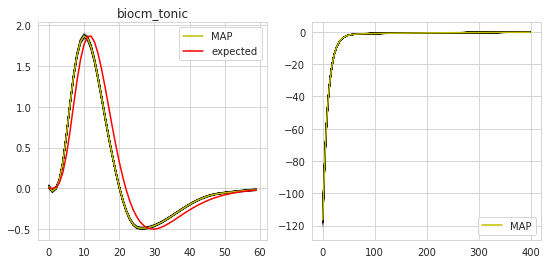

In [11]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
theta = np.median(pos, 0)
print("MLE:", w0[:3])
print("MAP:", theta[:3])

minprob = np.percentile(prob, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
for i in range(nwalkers):
    if prob[i] <= minprob: continue
    k = strf.from_basis(pos[i,3:], kcosbas)[::-1]
    axes[0].plot(k, 'k', alpha=0.01)

kmap = strf.from_basis(theta[3:], kcosbas)[::-1]
# expected kernel due to the filtering properties of the membrane
axes[0].plot(kmap, 'y', label="MAP")
axes[0].plot(kconv * kmap.max() / kconv.max(), 'r', label="expected")

axes[0].set_title(model_name)
axes[0].legend()

# posterior distribution of post-spike kernels
t = np.arange(0, 400)
for i in range(nwalkers):
    axes[1].plot(t, 
                 - pos[i,1] * np.exp(-t / ataus[0]) - pos[i,2] * np.exp(-t / ataus[1]),
                 'k', alpha=0.01)
axes[1].plot(t, - theta[1] * np.exp(-t / ataus[0]) - theta[2] * np.exp(-t / ataus[1]), 'y', label="MAP")
axes[1].legend()
# save the results
outfile = os.path.join("..", "..", "results", "1d_biocm", model_name)
plt.savefig(outfile + "_rf.pdf")

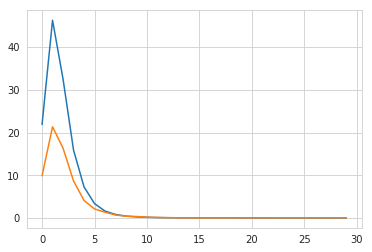

In [12]:
for ff in (kconv, kmap):
    K = np.fft.fft(ff)
    plt.plot(np.absolute(K[:K.size//2]))

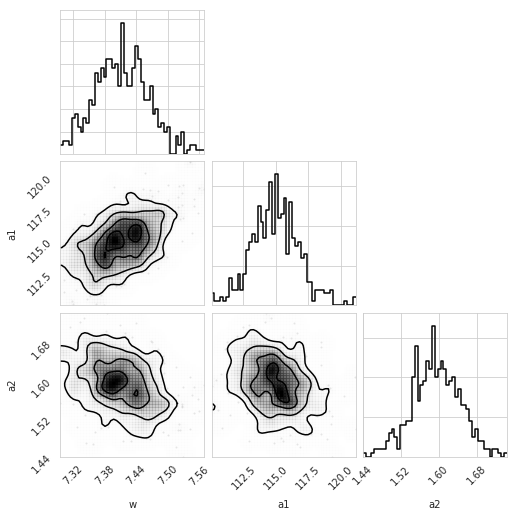

In [13]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:3]
matlabs = ['w','a1','a2']
c = corner(mpos,
           #range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs)

In [14]:
# simulate test data
def predict_spikes_current(I, params, dt, upsample):
    state = mat.voltage(I, fullmatparams, dt, upsample=upsample)
    V = state[:, 0]
    return V, predict_spikes_voltage(V, params, dt, 1)

def predict_spikes_voltage(V, params, dt, upsample):
    omega, a1, a2  = params
    return mat.predict_poisson(V - omega, (a1, a2), ataus, t_refract, dt, upsample)

np.random.seed(1000)
mat.random_seed(1000)
test_data = []
test_stim = np.random.randn(n_frames)
test_stim[:100] = 0
        
I = filter_stimulus(test_stim, k1)
for i in range(n_test):
    In, V, spike_t = generate_spikes(I, trial_noise_sd, model_dt, upsample)
    spike_v = np.zeros(V.size, 'i')
    spike_v[spike_t] = 1
    H = mat.adaptation(spike_v, ataus, model_dt)
    d = {"H": H,
         "duration": duration,
         "spike_t": np.asarray(spike_t), 
         "spike_v": spike_v,
        }
    test_data.append(d)

CC: 0.8824989691811974/0.8106187540684511 = 1.088673269341455


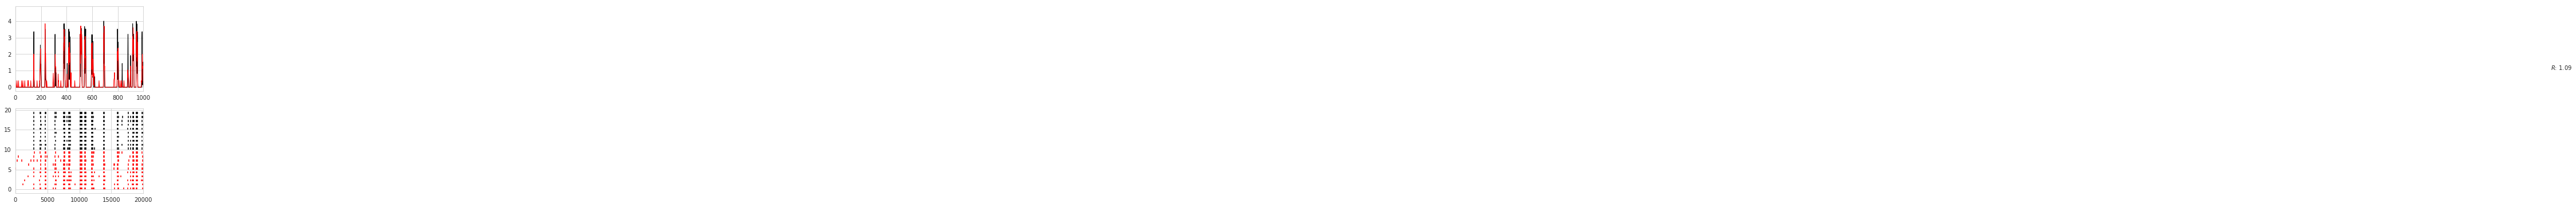

In [16]:
from dstrf import spikes, performance

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(4, 6))

duration = 20000
# posterior prediction
spike_v = np.stack([d["spike_v"] for d in test_data], axis=1)
spike_h = np.stack([d["H"] for d in test_data], axis=2)    
mltest = mle.mat(test_stim, kcosbas, spike_v, spike_h, stim_dt, model_dt, nlin="exp")

samples = np.random.permutation(nwalkers)[:n_test]
pred_spikes = []
for i, idx in enumerate(samples):
    sample = pos[idx]
    V = mltest.V(sample)
    S = predict_spikes_voltage(V, sample[:3], model_dt, upsample)
    spk_t = S.nonzero()[0]
    axes[1].vlines(spk_t, i, i + 0.5, 'r')
    pred_spikes.append(S)

for j, d in enumerate(test_data):
    axes[1].vlines(d["spike_t"], i + j + 1, i + j + 1.5)
    
test_psth = spikes.psth(spike_v, upsample, 1)    
pred_psth = spikes.psth(np.asarray(pred_spikes).T,upsample,1)

eo = performance.corrcoef(spike_v[::2], spike_v[1::2], upsample, 1)
cc = np.corrcoef(test_psth, pred_psth)[0, 1]
print("CC: {}/{} = {}".format(cc, eo, cc / eo))

axes[0].plot(test_psth,linewidth=1,color='k',label="data")
axes[0].plot(pred_psth,linewidth=1,color='r',label="estimate")    
t = axes[0].text(duration,1.04,"$R$: {:.2f}".format(cc / eo),fontsize=10)
t.set_ha("right")

axes[0].set_xlim(0, duration // upsample);
axes[1].set_xlim(0, duration);

plt.savefig(outfile + "_predict.pdf");
np.savez(outfile + "_samples.npz", pos=pos, prob=prob, eo=eo, cc=cc);